============================================================================================

# RandomForest

============================================================================================


In [3]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)

In [20]:
import pandas as pd
import numpy as np
import os
import re
import random
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from sklearn.decomposition import PCA

import fns_models as fns


% matplotlib inline

from subprocess import check_output
print(check_output(["ls", "data"]).decode("utf-8"))

athenaeum_authors_preview.csv
athenaeum_painting_filtered.csv
athenaeum_paintings.csv
athenaeum_paintings_sizes.csv
color_histograms.csv
complete_data.csv
images
images_athenaeum
images_sizes_2325.csv
net_predicted.csv
painter_info_clean.csv
painting_info_clean.csv
resized_200
test_author200.csv
test_data.csv
test_hist_author_knn.csv
test_hist_author_rf.csv
train_author200.csv
train_data.csv
train_hist_author_knn.csv
train_hist_author_rf.csv



In [ ]:
# Do not run this
# def get_data():
#     train = pd.read_csv("data/train_hist_author_knn.csv")
#     test = pd.read_csv("data/test_hist_author_knn.csv")

#     print "[INFO] The size of train histogram for Random Forest" + str(train.shape)
#     print "[INFO] The size of test histogram for Random Forest" + str(test.shape)

#     train_labels = train.author_id
#     train = train.drop(['author_id', 'painting_id'], axis=1)
#     test_labels = test.author_id
#     test = test.drop(['author_id', 'painting_id'], axis=1)
    
#     train.iloc[:,:-2] = train.iloc[:, :-2]\
#         .apply(lambda x: x.astype(np.float) / (x.sum()/3), axis = 1, raw = True)
#     test.iloc[:,:-2] = test.iloc[:, :-2]\
#         .apply(lambda x: x.astype(np.float) / (x.sum()/3), axis = 1, raw = True)
    
#     return train, train_labels, test, test_labels

# train_data, train_labels, test_data, test_labels = get_data()

In [50]:
# Pick top 3 authors
def get_top_author(num_author=3):
    train = pd.read_csv("data/train_hist_author_knn.csv")
    test = pd.read_csv("data/test_hist_author_knn.csv")

    print "[INFO] The size of train histogram for Random Forest" + str(train.shape)
    print "[INFO] The size of test histogram for Random Forest" + str(test.shape)

     
    train.iloc[:,2:-2] = train.iloc[:, 2:-2]\
        .apply(lambda x: x.astype(np.float) / (x.sum()/3), axis = 1, raw = True)
    test.iloc[:,2:-2] = test.iloc[:, 2:-2]\
        .apply(lambda x: x.astype(np.float) / (x.sum()/3), axis = 1, raw = True)
        
    author_index = train.author_id.value_counts().index[:num_author]
    train = train.loc[train['author_id'].isin(author_index)]
    test = test.loc[test['author_id'].isin(author_index)]
    
    
    print train.author_id.value_counts().head(10)
    print "[trian above] " + '=' * 50 + "[test below]"
    print test.author_id.value_counts().head(10)
    

    train_labels = train.author_id
    print train_labels.shape
    print  train.shape
    train = train.drop(['author_id', 'painting_id'], axis=1)
    test_labels = test.author_id
    test = test.drop(['author_id', 'painting_id'], axis=1)
   
    return train, train_labels, test, test_labels




[INFO] The size of train histogram for Random Forest(49890, 34)
[INFO] The size of test histogram for Random Forest(12473, 34)
24      1369
1793    1338
368     1335
Name: author_id, dtype: int64
[trian above] ==================================================[test below]
24      342
1793    335
368     334
Name: author_id, dtype: int64
(4042,)
(4042, 34)


In [ ]:
train, train_labels, test, test_labels = fns.get_top_author(3)


================================================================================================================

# Bayesian Optimization + Random Forest

[bayesian-optimization](https://github.com/fmfn/BayesianOptimization/blob/master/bayes_opt/bayesian_optimization.py)

================================================================================================================

In [7]:
def rf_evaluate(max_features, max_depth, n_estimators):
    
    random.seed(2017)
#     params['max_features'] = int(max_features)
#     params['max_depth'] = int(max_depth)
#     params['n_estimators'] = int(n_estimators)
    
    rfc = RandomForestClassifier(n_jobs = 4, n_estimators=int(n_estimators), oob_score=True,
                                max_depth = int(max_depth), max_features = int(max_features))
    #scores = cross_val_score(rfc, X=train, y = train_labels, cv=5, n_jobs = 2)
    
    # The mean score and the 95% confidence interval of the score estimate are hence given by:
    #print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    #return scores.mean()
    rfc.fit(train, train_labels)
    return rfc.oob_score_

def rf_pca_evaluate(max_features,
                    max_depth,
                    n_estimators):
    
    random.seed(2017)
    
    rfc = RandomForestClassifier(n_jobs = 4, n_estimators=int(n_estimators), oob_score=True,
                                max_depth = int(max_depth), max_features = int(max_features))
    
    rfc.fit(pca_transformed, train_labels)
    return rfc.oob_score_

def rf_bo(rf_fnc=rf_evaluate):
    num_iter = 25
    init_points = 5
    random_state = 2017
    # params = {
    #     #'eta': 0.1,
    #     #'silent': 1,
    #     'eval_metric': 'mae',
    #     'verbose_eval': True,
    #     #'seed': random_state
    # }

    rfBO = BayesianOptimization(rf_fnc, {'max_features': (5, 7),
                                             'max_depth': (2, 10),
                                             'n_estimators': (100, 900)})

    rfBO.maximize(init_points=init_points, n_iter=num_iter)
    
    print "Bayesian Optimization Best Score: %d" % rfBO.res['max']['max_val']

    print "Bayesian Optimization Best Parameters: %s" % str(rfBO.res['max']['max_params'])
    
    print (rfBO.res['max'])
    
    fns.plot_bo(rf_fnc, rfBO)

#     print "Bayesian Optimization  Parameters: %s" % str(rfBO.res['all'])



In [ ]:
# Run BO for color histogram
rf_bo(rf_evaluate)

In [ ]:
# Choose the best params from BO results then predict 
best_estimators = 
best_max_depth = 
best_max_features = 
best_rfc = RandomForestClassifier(n_jobs = 4, n_estimators=best_estimators, oob_score=False,
                                max_depth = best_max_depth, max_features = best_max_features)

best_rfc.fit(train, train_labels)

# use the best params to predict
rfc_true, rfc_pred = test_labels, best_rfc.predict(test)
rfc_pred

In [ ]:
def result_table(y_true, y_pred):
    rslt = y_true  == y_pred

    test_data_df = pd.DataFrame()
    test_data_df.insert(0,'actual',y_true)
    test_data_df.insert(1,'predictions',y_pred)
    test_data_df.insert(2,'results',rslt)
    
    return test_data_df

In [ ]:

test_data_df = fns.result_table(rfc_true, rfc_pred)
test_data_df

================================================================================================================

# PCA

================================================================================================================

In [67]:
## Get 15 principal components
pca = PCA(n_components=15)
pca.fit(train)
pca_transformed = pca.transform(train)

pca_transformed_test = pca.transform(test)

0.9647590224311009

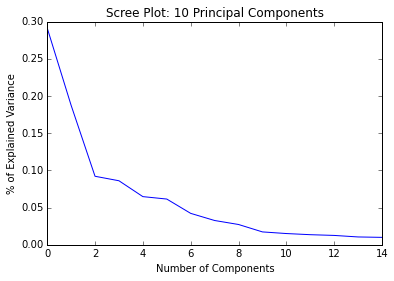

In [52]:
plt.plot(pca.explained_variance_ratio_)
plt.title("Scree Plot: 10 Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("% of Explained Variance")
sum(pca.explained_variance_ratio_)

======================================================================================================

# Random Forest + PCA

======================================================================================================

In [53]:
# Run BO for pca of color histogram
rf_bo(rf_pca_evaluate)

In [54]:
# Choose the best params from BO results then predict 
best_pca_estimators = 
best_pca_max_depth = 
best_pca_max_features = 
best_pca_rfc = RandomForestClassifier(n_jobs = 4, n_estimators=best_pca_estimators, oob_score=False,
                                max_depth = best_pca_max_depth, max_features = best_pca_max_features)

best_pca_rfc.fit(pca_transformed, train_labels)

# use the best params to predict
rfc_pac_true, rfc_pca_pred = test_labels, best_pca_rfc.predict(pca_transformed_test)
rfc_pca_pred

(4042,)

In [66]:
# accuracy of training dataset
best_pca_rfc.score(pca_transformed, train_labels)

0.92726373082632363

In [68]:
# accuracy of testing dataset
best_pca_rfc.score(pca_transformed_test, test_labels)

0.70524233432245298

In [ ]:
test_data_df = result_table(rfc_true, rfc_pred)
test_data_df